In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
# from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank
# from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import combinations

from funcs.data_process import *
from funcs.VECM import *
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Data preparation

In [2]:
tickers = ['MGC', 'VONE', 'VOO', 'RSP', 'SPY', 'VV', 'IWV', 'FEX', 'IVV', 'ITOT', 'IYY', 'IWB', 'VTI', 'SCHB']

In [43]:
try:
    data = pd.read_csv('./sp500_etf.csv', index_col = 0)
    data.index = pd.to_datetime(data.index)
except:
    data = price_data()
    data.to_csv('./sp500_etf.csv')
    np.log(data).to_csv("./sp500_etf_log.csv")

In [45]:
years = data.index.year.unique()

## Cointegrated Pairs

### Example

In [10]:
price_in, price_out, ret_in, ret_out = yearly_sample(2015, data)
pair = ['IVV','SPY']

train = ret_in[pair]
test = ret_out[pair]

train_log = np.log(price_in[pair])
train_price = price_in[pair]
test = price_out[pair]

1) Price series should be cointegrated - to form a stationary spread

In [11]:
jres = coint_johansen(train_price, det_order=0, k_ar_diff=4)
jres.trace_stat_crit_vals,jres.trace_stat

(array([[13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]),
 array([68.9579743 ,  1.27630391]))

2) Return series better be cointegrated - if not, the spread could be volatile and non-stationary in out-sample

In [12]:
jres2 = coint_johansen(train, det_order=0, k_ar_diff=4)
jres2.trace_stat_crit_vals, jres2.trace_stat

(array([[13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]),
 array([77.68137227,  2.0145749 ]))

Sprad is stationary, but not strictly random walk.

<Axes: xlabel='date'>

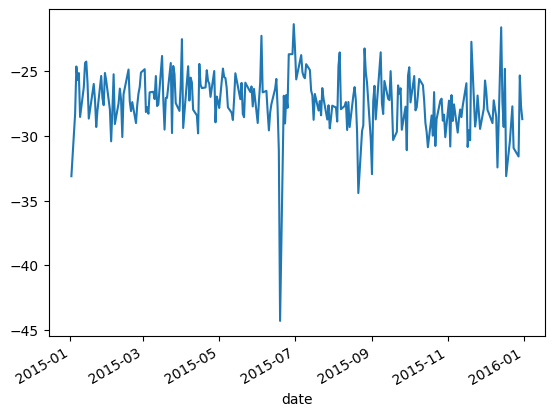

In [13]:
spread = jres.evec[:,0] @ test.T

i0 = spread.diff()
spread.plot()

In [14]:
ts.adfuller(spread, regression = 'n'), ts.adfuller(spread, regression = 'c')

((0.01297451139785009,
  0.6885791245108992,
  6,
  245,
  {'1%': -2.5749261391087046,
   '5%': -1.9421502633766543,
   '10%': -1.6157794081377657},
  1075.4926131689504),
 (-13.036109955577079,
  2.291495551479312e-24,
  0,
  251,
  {'1%': -3.4566744514553016,
   '5%': -2.8731248767783426,
   '10%': -2.5729436702592023},
  1054.3171053995943))

In [46]:
def jo_yearly(year, price_in, price_out, ret_in, ret_out):
    result = []
    for pair in combinations(tickers, 2):
        temp = get_johansen_result(pair, price_in, price_out, ret_in, ret_out)
        temp['year'] = year
        result.append(temp)
    johansen_result = pd.DataFrame(result)
    return johansen_result


In [3]:
try:
    vecm_res = pd.read_csv("./result/vecm_res.csv")
except:
    vecm_res = []
    for y in tqdm(range(2013, 2023)):
        vecm_res.append(jo_yearly(y, *yearly_sample(y, data)))
    vecm_res = pd.concat(vecm_res)
    vecm_res.to_csv('./result/vecm_res.csv', index = False)

In [4]:
vecm_res.sort_values('in_adf_n')

,pair,stat1_ret,stat2_ret,stat1_price,stat2_price,in_adf_n,in_adf_c,out_adf_n,out_adf_c,order,year
295,"('VONE', 'IWB')",0.01,1.0,0.01,1.0,1.838047e-15,1.942716e-15,6.040855e-01,1.863447e-01,0,2016
113,"('VONE', 'IWB')",0.01,1.0,0.01,1.0,1.870190e-07,3.464462e-24,4.804201e-02,8.766911e-16,0,2014
849,"('VOO', 'IVV')",0.01,1.0,0.01,1.0,1.001176e-06,1.587415e-05,3.599359e-09,2.138801e-08,9,2022
526,"('FEX', 'ITOT')",0.05,1.0,0.05,1.0,4.137804e-04,6.695948e-03,9.626773e-01,9.715532e-01,1,2018
529,"('FEX', 'VTI')",0.05,1.0,0.05,1.0,9.871794e-04,9.691406e-03,9.826553e-01,9.820555e-01,1,2018
...,...,...,...,...,...,...,...,...,...,...,...
618,"('FEX', 'IYY')",1.00,1.0,1.00,1.0,9.687449e-01,8.856043e-01,9.999790e-01,9.485716e-01,1,2019
897,"('IVV', 'IWB')",1.00,1.0,1.00,1.0,9.693022e-01,9.640791e-01,2.787445e-01,1.326728e-01,9,2022
851,"('VOO', 'IYY')",1.00,1.0,1.00,1.0,9.794591e-01,9.808446e-01,3.357392e-01,1.134209e-01,9,2022
870,"('SPY', 'IYY')",1.00,1.0,1.00,1.0,9.800807e-01,9.807688e-01,4.052350e-01,6.788360e-02,9,2022


In [5]:
vecm_res[(vecm_res['stat1_price'] == 1) & (vecm_res['in_adf_c'] < 0.05)]

,pair,stat1_ret,stat2_ret,stat1_price,stat2_price,in_adf_n,in_adf_c,out_adf_n,out_adf_c,order,year
3,"('MGC', 'SPY')",1.00,1.0,1.0,1.0,0.680597,0.045890,0.989744,0.508759,3,2013
7,"('MGC', 'IVV')",1.00,1.0,1.0,1.0,0.728589,0.034400,0.972153,0.496617,6,2013
57,"('VV', 'IVV')",1.00,1.0,1.0,1.0,0.672390,0.042579,0.985584,0.922116,6,2013
85,"('IYY', 'IWB')",0.10,1.0,1.0,1.0,0.490558,0.021460,0.688456,0.008667,6,2013
88,"('IWB', 'VTI')",1.00,1.0,1.0,1.0,0.251798,0.019954,0.880380,0.722977,6,2013
89,"('IWB', 'SCHB')",0.10,1.0,1.0,1.0,0.258849,0.010654,0.813056,0.553506,6,2013
150,"('VV', 'IYY')",1.00,1.0,1.0,1.0,0.552849,0.008512,0.871133,0.816270,4,2014
151,"('VV', 'IWB')",1.00,1.0,1.0,1.0,0.758501,0.029912,0.921834,0.830288,7,2014
153,"('VV', 'SCHB')",1.00,1.0,1.0,1.0,0.767332,0.018403,0.782687,0.664355,2,2014
160,"('IWV', 'SCHB')",0.10,1.0,1.0,1.0,0.656894,0.035386,0.482595,0.385667,7,2014


In [42]:
cond1 = lambda x: x['in_adf_c'] < 0.1
cond2 = lambda x: x['out_adf_c'] < 0.1

In [43]:
vecm_res.groupby('year').apply(lambda x: len(x[cond1(x) & cond2(x)])/ len(x[cond1(x)]))

year
2013    0.222222
2014    0.128205
2015    0.181818
2016    0.166667
2017    0.294118
2018    0.063830
2019    0.100000
2020    0.043478
2021    0.363636
2022    0.214286
dtype: float64

In [21]:
vecm_res[(vecm_res.year == 2019) & (vecm_res.pair == "('SPY', 'VV')")]

,pair,stat1_ret,stat2_ret,stat1_price,stat2_price,in_adf_n,in_adf_c,out_adf_n,out_adf_c,year
553,"('SPY', 'VV')",0.1,0.05,0.1,0.05,0.521419,0.010751,0.848763,0.49297,2019


In [73]:
pair = ('IWV', 'ITOT')

In [74]:
vecm_res[vecm_res.pair == str(pair)]

,pair,stat1_ret,stat2_ret,stat1_price,stat2_price,in_adf_n,in_adf_c,out_adf_n,out_adf_c,order,year
65,"('IWV', 'ITOT')",1.00,1.0,1.00,1.0,0.539925,0.256666,0.983865,0.803986,5,2013
156,"('IWV', 'ITOT')",1.00,1.0,1.00,1.0,0.595479,0.163449,0.850376,0.738244,5,2014
247,"('IWV', 'ITOT')",1.00,1.0,1.00,1.0,0.808611,0.312844,0.574632,0.666014,4,2015
338,"('IWV', 'ITOT')",1.00,0.1,1.00,0.1,0.848428,0.285824,0.916092,0.820207,1,2016
429,"('IWV', 'ITOT')",1.00,1.0,1.00,1.0,0.823385,0.355152,0.999932,0.956092,2,2017
520,"('IWV', 'ITOT')",0.05,1.0,0.05,1.0,0.577265,0.018807,0.133049,0.342503,5,2018
611,"('IWV', 'ITOT')",0.10,0.1,0.05,0.1,0.489227,0.087686,0.975412,0.505506,8,2019
702,"('IWV', 'ITOT')",1.00,1.0,1.00,1.0,0.090267,0.074824,0.048673,0.345323,10,2020
793,"('IWV', 'ITOT')",0.01,1.0,0.05,1.0,0.607404,0.011609,0.234085,0.032494,9,2021
884,"('IWV', 'ITOT')",0.10,1.0,1.00,1.0,0.542529,0.020738,0.815374,0.019908,9,2022


In [82]:
df = data[list(pair)].loc['2015']

In [83]:
df

,IWV,ITOT
date,,
2015-01-02,107.816657,41.201651
2015-01-05,105.981329,40.463790
2015-01-06,104.851897,40.094859
2015-01-07,106.184274,40.547239
2015-01-08,108.081367,41.285100
...,...,...
2015-12-24,109.230342,41.801232
2015-12-28,108.978617,41.680870
2015-12-29,110.114334,42.106162


In [510]:
ord = max(select_order(test_ret, 10).selected_orders.values())
j_res = get_johansen(test_ret, ord, mode = 0)
a, b = j_res.trace_stat, j_res.trace_stat_crit_vals

j_test = pd.DataFrame(b, columns = ['10%', '5%', '1%'], index = ['r=0', 'r<=1'])
j_test['test'] = a
# j_test.to_latex(f'./writeups/{test_pair[0].lower()}_{test_pair[1].lower()}_johansen.tex')
j_test

,10%,5%,1%,test
r=0,13.4294,15.4943,19.9349,15.078611
r<=1,2.7055,3.8415,6.6349,4.917945


In [511]:
ord = max(select_order(oos_ret, 10).selected_orders.values())
j_res = get_johansen(oos_ret, ord, mode = 0)
a, b = j_res.trace_stat, j_res.trace_stat_crit_vals

j_test = pd.DataFrame(b, columns = ['10%', '5%', '1%'], index = ['r=0', 'r<=1'])
j_test['test'] = a
# j_test.to_latex(f'./writeups/{test_pair[0].lower()}_{test_pair[1].lower()}_out_johansen.tex')
j_test

,10%,5%,1%,test
r=0,13.4294,15.4943,19.9349,21.217468
r<=1,2.7055,3.8415,6.6349,0.908088


In [485]:
seo = [9.391, 8.239, 8.4667, 8.8685, 9.1096, 30]
seo = pd.DataFrame(seo, columns = ['Seo Test'], index = ['sup-Wald', '10%', '5%', '2.5%', '1%', 'nboot']).T
seo.to_latex("./writeups/iwv_itot_seo_test.tex")

In [513]:
hseo = [29.64, 14.91, 15.31, 17.23, 0.00586, 100]
hseo = pd.DataFrame(hseo, columns = ['H-Seo Test'], index = ['Test Statistics', '10%', '5%', '1%', 'threshold', 'nboot']).T
hseo.to_latex("./writeups/spy_vv_hseo_test.tex")

[1, -1.0159263566131067]
(-6.515243234404821, 1.0754069487507229e-08, 5, 497, {'1%': -3.4435761493506294, '5%': -2.867372960189225, '10%': -2.5698767442886696}, -1686.1303116963536)
True


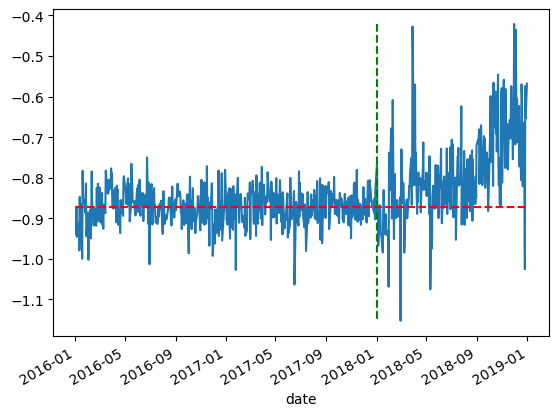

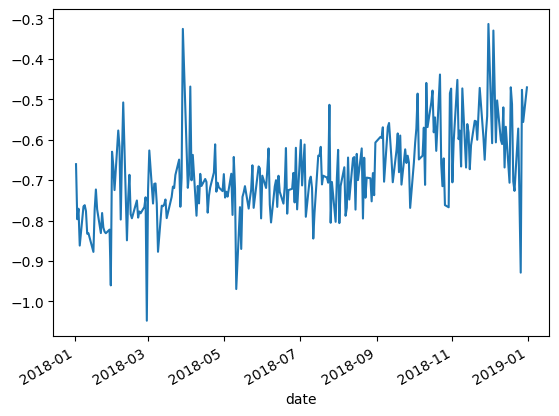

[ 1.         -1.01166234]
(-0.838088416981259, 0.807677127030318, 12, 490, {'1%': -3.4437660979098843, '5%': -2.8674565460819896, '10%': -2.569921291128696}, -1660.1099595229616)


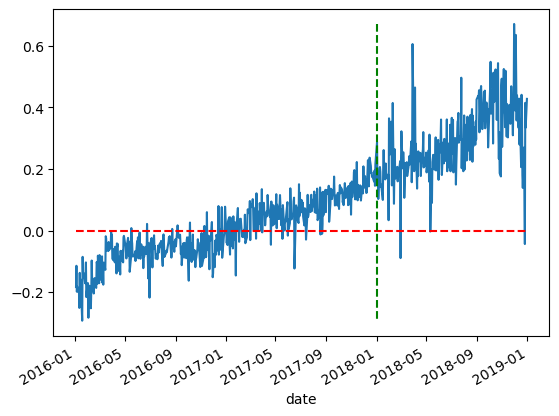

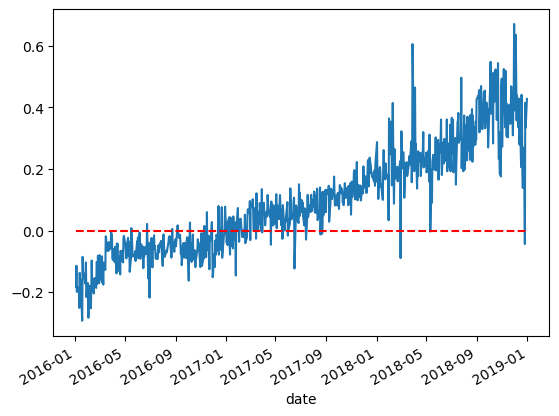

In [501]:
sp = common_trend_ols(test_price, oos_price)
plt.show()
spv = common_trend_vecm(test_price, test_price, oos_price, oos_price)

### Kernel Estimation

In [71]:
spy = price_in['SPY'].pct_change().dropna()
in_sample = ret_in[['IVV','VOO']].iloc[1:]
out_spy = price_out['SPY'].pct_change().dropna()

In [291]:
in_sample = ret_in[['RSP','IWV']].iloc[1:]

In [421]:
import statsmodels.nonparametric.bandwidths as bw
import statsmodels.api as sm

def normal_pdf(x, scale = 2.5, const = 1):
    return np.exp(-0.5 * (x*scale)**2) / const

def gaussian_kernel(x, ker_x):
    h = bw.bw_scott(ker_x)
    kernel_val = normal_pdf((x - ker_x)/h) / h
    return kernel_val

def kernel_regresssion(z, x_train, y_train, z_train):
    z = np.asarray(z)
    num_prep = x_train * y_train
    den_prep = x_train **2
    def kernel(z):
        w = gaussian_kernel(z, z_train)
        return np.sum(num_prep * w) / np.sum(den_prep * w)
    kernel = np.vectorize(kernel)
    return kernel(z)

def get_max_chi_pval(p, k, m, nboot = int(1e4)):
    chi_cval = np.zeros(nboot)
    for i in range(nboot):
        chi_cval[i] = np.random.chisquare(k, m).max()
    return (chi_cval > p).mean()


u_range = np.arange(-1, 1, 1e-5)
def stability_test(x_train, y_train, z_train):
    beta_const = sm.OLS(y_train, x_train).fit().params[0]
    betas = kernel_regresssion(z_train, x_train, y_train, z_train)
    u = y_train - betas * x_train
    n = len(x_train)
    h = bw.bw_scott(z_train)
    
    sig_u = u.var()
    xt_2 = x_train **2
    deno_prep = np.vectorize(lambda z: 1/n**2 * np.sum(gaussian_kernel(z, z_train) * xt_2))
    deno = deno_prep(z_train)
    nu0 = np.sum(normal_pdf(u_range) ** 2) * 1e-5
    omega = sig_u * nu0/deno
    
    T = n**2 * np.sqrt(h) * (betas - beta_const) / np.sqrt(omega) # Is m * 1 vector where m = len(z_train)
    Tm = abs(T).max()
    pval = get_max_chi_pval(Tm, 1, n)
    return Tm, pval


def coint_test(x_train, y_train, z_train):
    beta_const = sm.OLS(y_train, x_train).fit().params[0]
    betas = kernel_regresssion(z_train, x_train, y_train, z_train)
    u = y_train - betas * x_train
    n = len(u)
    time = np.arange(n)
    mod = sm.OLS(u**2, sm.add_constant(time)).fit()
    b_hat = mod.params[1]
    u2_mean = (u**2).mean()
    
    M = int(np.sqrt(n))
    khM_ch = lambda h: np.sum((u.iloc[:-h] - u2_mean) * (u.iloc[h:]**2 - u2_mean))/n
    omega_val = np.vectorize(khM_ch)
    M_range = np.arange(-M, M)
    omega2 = np.sum(omega_val(M_range))
    t_sum = time.var() * n
    s_b = np.sqrt(omega2/t_sum)
    return b_hat/s_b

In [420]:
pval = stability_test(in_sample.iloc[:,0], in_sample.iloc[:,1], spy)
pval

(1926.2885421761412, 0.0)

In [422]:
coint_test(in_sample.iloc[:,0], in_sample.iloc[:,1], spy)

-0.07222983131174325

In [410]:
np.sum(normal_pdf(u_range, scale = 2.5, const =1)) * 1e-5

0.9901990517066612

In [409]:
normal_pdf(0, scale = 2.5, const = 1)

1.0

In [406]:
from scipy.optimize import minimize

In [417]:
def test(z):
    x, y= z[0], z[1]
    return 2 - normal_pdf(0, scale = x, const = y) - np.sum(normal_pdf(u_range)) * 1e-5

In [294]:
beta = kernel_regresssion(spy, in_sample.iloc[:,0], in_sample.iloc[:,1], spy)
beta

array([0.96119512, 0.96571633, 0.95379373, 0.96026454, 0.95921012,
       0.955052  , 0.97620363, 0.96817071, 0.95320917, 0.96376121,
       0.96509715, 0.95473747, 0.95921552, 0.96749036, 0.99396189,
       0.96444058, 0.95358178, 0.9687852 , 0.96785453, 0.96421659,
       0.99745134, 0.95544312, 0.9636703 , 0.96846284, 0.96802626,
       0.95659628, 0.96820381, 0.95959274, 0.95315917, 0.95326142,
       0.95795166, 0.96498167, 0.95352946, 0.9634368 , 0.95327517,
       0.96171182, 0.96066438, 0.95317174, 0.95535332, 0.96564216,
       0.97116989, 0.95861382, 0.95575371, 0.95976085, 0.96207347,
       0.96442213, 0.96014507, 0.97010782, 0.96568588, 0.96322378,
       0.95580263, 0.96419749, 0.95347419, 0.9654266 , 0.96518805,
       0.95319291, 0.96591838, 0.96509856, 0.95315929, 0.95957132,
       0.95458643, 0.95422123, 0.9638085 , 0.97120616, 0.96990619,
       0.95349649, 0.96803751, 0.99396732, 0.9683433 , 0.95829498,
       0.95515055, 0.96766903, 0.95750765, 0.95406398, 0.95326

<AxesSubplot: >

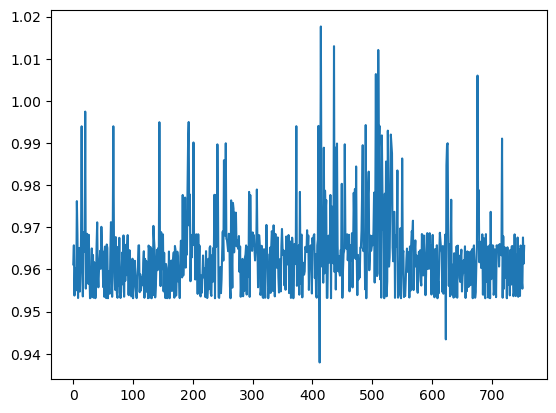

In [295]:
pd.Series(beta).plot()

## VARMA model

In [891]:
sample_pair = pairs[0]

In [892]:
out_sample = get_sample(y+1)

In [893]:
select_order(out_sample[list(sample_pair)].dropna(), 10).summary()

,AIC,BIC,FPE,HQIC
0,-8.405*,-8.318*,0.0002238*,-8.370*
1,-8.394,-8.250,0.0002261,-8.336
2,-8.380,-8.177,0.0002295,-8.298
3,-8.396,-8.136,0.0002258,-8.291
4,-8.367,-8.049,0.0002324,-8.239
5,-8.349,-7.973,0.0002366,-8.198
6,-8.316,-7.883,0.0002445,-8.142
7,-8.289,-7.797,0.0002514,-8.091
8,-8.266,-7.717,0.0002573,-8.045
9,-8.237,-7.629,0.0002650,-7.992


In [894]:
smt.VAR(in_sample[list(sample_pair)]).select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,0.5133,0.5421,1.671,0.5249
1,-8.927,-8.841*,0.0001327,-8.892
2,-8.959*,-8.814,0.0001286*,-8.900*
3,-8.939,-8.737,0.0001312,-8.858
4,-8.916,-8.656,0.0001342,-8.811
5,-8.895,-8.578,0.0001370,-8.768
6,-8.918,-8.544,0.0001339,-8.767
7,-8.890,-8.458,0.0001378,-8.716
8,-8.862,-8.372,0.0001418,-8.664
9,-8.856,-8.308,0.0001426,-8.635


In [580]:
varmax_model = sm.tsa.VARMAX(in_sample[list(sample_pair)], order=(2, 1), trend='c').fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91528D+00    |proj g|=  2.38319D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      2     18      1     0     0   2.246D+00  -1.915D+00
  F =  -1.9152968832509467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [277]:
varmax_model.summary()

Dep. Variable:,"['FAX', 'IAU']",No. Observations:,251
Model:,"VARMA(4,1)",Log Likelihood,774.245
,+ intercept,AIC,-1498.490
Date:,"Fri, 17 Feb 2023",BIC,-1410.354
Time:,14:57:41,HQIC,-1463.022
Sample:,0,,
,- 251,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.08, 0.07",Jarque-Bera (JB):,"346.24, 0.29"
Prob(Q):,"0.78, 0.79",Prob(JB):,"0.00, 0.86"
Heteroskedasticity (H):,"0.67, 0.93",Skew:,"0.42, 0.06"


In [278]:
var_temp = smt.VAR(in_sample[list(sample_pair)]).fit(maxlags=4, ic='aic')
var_temp.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Feb, 2023
Time:                     14:57:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5926
Nobs:                     247.000    HQIC:                  -11.7454
Log likelihood:           780.314    FPE:                7.15089e-06
AIC:                     -11.8483    Det(Omega_mle):     6.65693e-06
--------------------------------------------------------------------
Results for equation FAX
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.054193         0.047052            1.152           0.249
L1.FAX         0.682494         0.063036           10.827           0.000
L1.IAU         0.012032         0.007603            1.582           0.114
L2.FAX         0

In [279]:
result = out_sample[list(sample_pair)].dropna()

In [254]:
pred = pd.DataFrame(columns = list(sample_pair))
for i in range(0, len(out_sample)-2, 2):
    temp = var_temp.forecast(out_sample[list(sample_pair)].iloc[i:i+2].values, steps=2)
    pred.loc[result.index[i+2]] = temp[0]
    pred.loc[result.index[i+3]] = temp[1]

In [281]:
pred = pd.DataFrame(var_temp.forecast(out_sample[list(sample_pair)].iloc[0:4].values, steps=len(out_sample)-4), index = out_sample[list(sample_pair)].index[4:])

<AxesSubplot: xlabel='date'>

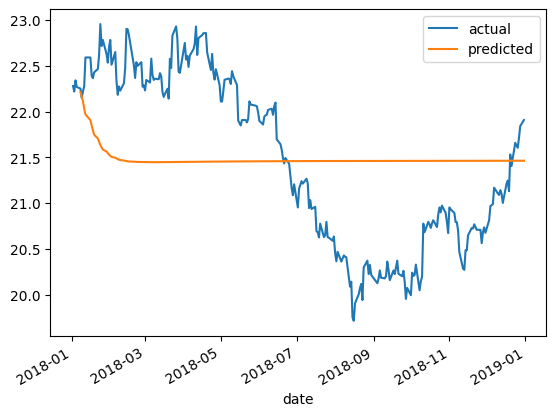

In [283]:
res_spread = pd.concat([result.diff(axis=1).iloc[:,1], pred.diff(axis=1)[1]], axis=1)
res_spread.columns = ['actual', 'predicted']
res_spread.plot()